In [140]:
qualitatives_attributes_col_idx <- c(3,5,6,8,9,10)
discretized_quantitatives_attributes_col_idx <- c(3,5)
quantitatives_attributes_col_idx <- c(1,2,4)
target_variables_idx <- 7
datasets_directory <- "../datasets/"
dataset_filename <- "HR_prediction-all.csv"
output_folder <- "output"
working_directory <- "P:/dev/62-62_Data_Mining/tp/tp02" #"C:/Users/huniv/jnotebook/data-mining/62-62_Data_Mining/tp/tp02" #P:\dev\62-62_Data_Mining\tp\tp02

In [141]:
# Ensure UTF-8 compatibility or fall back to a supported locale
try({
	Sys.setlocale("LC_ALL", "English_United States.utf8")
}, silent = TRUE)

if (Sys.getlocale() != "English_United States.utf8") {
	Sys.setlocale("LC_ALL", "English_United States")
	options(encoding = "UTF-8")
}


Warning message in Sys.setlocale("LC_ALL", "English_United States.utf8"):
"OS reports request to set locale to "English_United States.utf8" cannot be honored"

[1] ""

In [142]:
#mettre le paquet Naive Bayes à disposition
if (!requireNamespace("e1071", quietly = TRUE)) { 
  install.packages("e1071")
}

#for latex parsing of equations
if (!requireNamespace("latex2exp", quietly = TRUE)) { 
  install.packages("latex2exp")
}

# Check if the package is installed
if (!require("colorspace", quietly = TRUE)) { 
  install.packages("colorspace")
}

library(e1071)
library(latex2exp)
library(colorspace)

In [143]:
library(arules)
# Function to create an output directory if it doesn't exist
ensure_output_directory <- function(wd, folder_name) {
	output_dir <- file.path(wd, folder_name)
	if (!dir.exists(output_dir)) {
		dir.create(output_dir, recursive = TRUE)
	}
	return(output_dir)
}

In [144]:
setwd(working_directory)
#read data
# avec colClasses, nous contrôlons explicitement les types des différentes variables, 
# les valeurs qui nous intéressent le plus sont 
# factor: variables qualitatives
# numeric: pour les variables quantitatives
myData <- read.table(
  "../datasets/HR_prediction-all.csv",
  header = TRUE,
  sep = ",",
  colClasses = c(
    "NULL",         # Id - Remove   
    "numeric",      # satisfaction_level
    "numeric",      # last_evaluation
    "factor",       # number_project
    "integer",      # average_montly_hours
    "factor",       # time_spend_company
    "factor",       # Work_accident (categorical: 0 or 1)
    "factor",       # left (target variable: 0 or 1)
    "factor",       # promotion_last_5years (categorical: 0 or 1)
    "factor",       # department
    "factor"        # salary
  )
)

In [145]:
head(myData)

satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0.83,0.80,4,158,4,0,0,0,marketing,medium
1.00,0.39,2,210,5,0,0,0,sales,low
0.97,0.91,3,246,2,0,0,0,accounting,low
0.68,0.65,3,173,3,1,0,0,marketing,high
0.77,0.55,3,225,3,0,0,0,sales,medium
0.51,0.71,2,180,3,0,0,0,product_mng,low


In [146]:
# Print all column names with their indices
for (i in seq_along(colnames(myData))) {
	cat("Index:", i, "-> Column Name:", colnames(myData)[i], "\n")
}


Index: 1 -> Column Name: satisfaction_level 
Index: 2 -> Column Name: last_evaluation 
Index: 3 -> Column Name: number_project 
Index: 4 -> Column Name: average_montly_hours 
Index: 5 -> Column Name: time_spend_company 
Index: 6 -> Column Name: Work_accident 
Index: 7 -> Column Name: left 
Index: 8 -> Column Name: promotion_last_5years 
Index: 9 -> Column Name: department 
Index: 10 -> Column Name: salary 


In [147]:
evaluate_classification_model <- function(
  data, 
  target_col_idx, 
  n_iter, 
  shouldBeReproductible = TRUE, 
  model_function, 
  predict_function
) {
    # Ensures reproductibility
    if(shouldBeReproductible) {
        set.seed(42)
    }
    
    # Extract the target variable name
    target_name <- colnames(data)[target_col_idx]
    
    # Initialize a vector to store accuracies
    accuracies <- numeric(n_iter)
  
	# Initialize a variable to store the trained model
	final_model <- NULL
    
    for (i in 1:n_iter) {
        # Split data into training and testing sets
        train_idx <- sample(1:nrow(data), size = floor(2/3 * nrow(data)))
        train_data <- data[train_idx, ]
        test_data <- data[-train_idx, ]
        
        # Train a Naive Bayes on data.
        # The parameter:
        #   formula=left~.
        # sets the target/class variable to be the left and use as predictive variables all the others
        
        # Build dynamic formula
        formula <- as.formula(paste(target_name, "~ ."))
        
        # Train the model using the input model function
        model <- model_function(formula, train_data)
        
        # Predict on test data using the input predict function
        predictions <- predict_function(model, test_data)
        
        # Calculate accuracy
        accuracy <- sum(predictions == test_data[[target_name]]) / nrow(test_data)
        accuracies[i] <- accuracy
        
        cat("Accuracy for iteration", i, ":", round(accuracy, 4), "\n")
	    
	    # Update the final model
	    final_model <- model
    }
    
    # Report the average accuracy
    avg_accuracy <- mean(accuracies)
    cat("\nAverage Accuracy over", n_iter, "splits:", round(avg_accuracy, 4), "\n")
	
	# Return the average accuracy and the last trained model
	return(list(
		average_accuracy = avg_accuracy,
		trained_model = final_model
	))
}

In [148]:
# Function to train the default classifier
trainDefaultClassifier <- function(train_data, target_idx) {
	# Extract the target column
	target_column <- train_data[,target_idx]
	
	# Find the majority class using a frequency table
	majority_class <- names(which.max(table(target_column)))
	
	# Return the majority class
	return(majority_class)
}

# Function to predict using the default classifier
predictDefaultClassifier <- function(test_data, majority_class) {
	# Create a vector of predictions with the majority class
	# Basically repeat the majority class for the number of rows in the test data
	predictions <- rep(majority_class, nrow(test_data))
	
	# Return the predictions
	return(predictions)
}

In [149]:
# Split the data into train and test sets
set.seed(42)

train_idx <- sample(1:nrow(myData), size = floor(2/3 * nrow(myData)))
train_data <- myData[train_idx, ]
test_data <- myData[-train_idx, ]

# Train the default classifier to find the majority class
majority_class <- trainDefaultClassifier(train_data, target_variables_idx)
cat("")
cat("Majority class identified:", majority_class, "\n")

# Use the default classifier to make predictions on the test set
predictions <- predictDefaultClassifier(test_data, majority_class)

# Evaluate the accuracy of the default classifier
accuracy <- sum(predictions == test_data[[target_variables_idx]]) / nrow(test_data)
cat("Default Classifier Accuracy:", round(accuracy, 4), "\n")

Majority class identified: 0 
Default Classifier Accuracy: 0.7618 


In [150]:
results <- evaluate_classification_model(
	myData,
	target_variables_idx,
	5,
	TRUE,
	naiveBayes,
	predict
)

# Extract results
avg_accuracy <- results$average_accuracy
trained_model <- results$trained_model

# Print the average accuracy
cat("Final Average Accuracy:", avg_accuracy, "\n")

# Inspect the final trained model
print(trained_model)

Accuracy for iteration 1 : 0.8605 
Accuracy for iteration 2 : 0.8692 
Accuracy for iteration 3 : 0.8587 
Accuracy for iteration 4 : 0.8599 
Accuracy for iteration 5 : 0.8542 

Average Accuracy over 5 splits: 0.8605 
Final Average Accuracy: 0.8605279 

Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
       0        1 
0.759976 0.240024 

Conditional probabilities:
   satisfaction_level
Y        [,1]      [,2]
  0 0.6680083 0.2156065
  1 0.4400875 0.2643933

   last_evaluation
Y        [,1]      [,2]
  0 0.7181958 0.1629576
  1 0.7199313 0.1989800

   number_project
Y            2          3          4          5          6          7
  0 0.07165417 0.34958547 0.35136202 0.17962890 0.04776944 0.00000000
  1 0.43687500 0.01875000 0.11250000 0.17687500 0.18875000 0.06625000

   average_montly_hours
Y       [,1]     [,2]
  0 198.4820 45.83999
  1 207.1481 60.86994

   time_spend_company
Y           10      

In [151]:
# Function to plot and save probability distributions
plot_and_save_probabilities <- function(output_dir, attribute_name, P_target, P_attribute_given_target, target_name, discretized = FALSE) {
	
	# Create the full path for the PDF file
	file_suffix <- ifelse(discretized, "_discretized", "")
	full_pdf_path <- file.path(output_dir, paste0(attribute_name, file_suffix, ".pdf"))
	
	# Open a PDF to save the plots
	pdf(file = full_pdf_path, width = 12, height = 6)
	
	# Set up a 1-row, 2-column layout for the plots
	par(mfrow = c(1, 2), mar = c(7, 4, 4, 2) + 0.1)
	
	# Visualize the probability distribution P(target)
	barplot(P_target,
	        main = paste("Probability Distribution P(", target_name, ")"),
	        xlab = paste("Category of ", target_name),
	        ylab = "Probability")


	P_attribute_given_target = t(P_attribute_given_target)
	# Visualize the conditional probability P(variable | target)
	barplot(P_attribute_given_target,
	        beside = FALSE,
	        main = paste0("Conditional Probability P(", attribute_name, " | ", target_name, ")"),
	        xlab = paste0("Category of ", attribute_name),
	        ylab = "Conditional Probability",
	        legend.text = rownames(P_attribute_given_target),
	        args.legend = list(x = "topright", inset = c(-0.1, 0), bty = "n"))
	
	# Close the PDF device
	dev.off()
	
}

# Function to analyze qualitative attributes
plot_probabilities_from_model_result <- function(wd, folder_name, model, data, variable_idx, target_idx) {
	
	# Ensure output directory exists
	output_dir <- ensure_output_directory(wd, folder_name)
	
	# Calculate the probability distribution P(variable)
	target_name <- colnames(data)[target_idx]
	P_target <- prop.table(model$apriori)
	print(P_target)  # Display the probability distribution
	
	# Calculate the conditional probability P(variable|target)
	# Example : Observing employe who had a work accident among the employe who left the company 
	# P (work_accident = 1 | left=1)
	attribute_name <- colnames(data)[variable_idx]
	P_attribute_given_target <- model$tables[[attribute_name]]
	# Display the conditional probability
	print(P_attribute_given_target)	
	
	# Plot and save the probabilities
	plot_and_save_probabilities(output_dir, attribute_name, P_target, P_attribute_given_target, target_name)
}


In [152]:
for (i in qualitatives_attributes_col_idx) {
	plot_probabilities_from_model_result(
			wd = working_directory,
			folder_name = output_folder,
			model = trained_model,
			data = myData,
			variable_idx = i,
			target_idx = target_variables_idx
	)
}


Y
       0        1 
0.759976 0.240024 
   number_project
Y            2          3          4          5          6          7
  0 0.07165417 0.34958547 0.35136202 0.17962890 0.04776944 0.00000000
  1 0.43687500 0.01875000 0.11250000 0.17687500 0.18875000 0.06625000
Y
       0        1 
0.759976 0.240024 
   time_spend_company
Y           10          2          3          4          5          6
  0 0.01993683 0.27615476 0.43031978 0.14271615 0.05783656 0.04382156
  1 0.00000000 0.01312500 0.44562500 0.25312500 0.22750000 0.06062500
   time_spend_company
Y            7          8
  0 0.01638373 0.01283064
  1 0.00000000 0.00000000
Y
       0        1 
0.759976 0.240024 
   Work_accident
Y           0         1
  0 0.8247138 0.1752862
  1 0.9518750 0.0481250
Y
       0        1 
0.759976 0.240024 
   promotion_last_5years
Y            0          1
  0 0.97572049 0.02427951
  1 0.99375000 0.00625000
Y
       0        1 
0.759976 0.240024 
   department
Y   accounting         hr         

In [171]:
# Single split
set.seed(1)
train_idx <- sample(1:nrow(myData), size = floor(2/3 * nrow(myData)))
train_data <- myData[train_idx, ]
test_data <- myData[-train_idx, ]
model <- naiveBayes(left ~ ., data = train_data)
# Calculate training accuracy
train_predictions <- predict(model, train_data)
train_accuracy <- sum(train_predictions == train_data[["left"]]) / nrow(train_data)
cat("Training Accuracy:", round(train_accuracy, 4), "\n")
# Test accuracy
test_accuracy <- sum(predictions == test_data[["left"]]) / nrow(test_data)
cat(paste("Test Accuracy:", round(test_accuracy, 4), "\n"))


Training Accuracy: 0.8608 
Test Accuracy: 0.7642 


In [172]:
#Examinons un instance de test particulier, par exemple le premier
test_data[1,]
#et les probabilités prédites de mort et de surv
pred1 <- predict(model, test_data[1,],type = "raw")
pred1

satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0.83,0.8,4,158,4,0,0,0,marketing,medium


0,1
0.964059,0.03594096


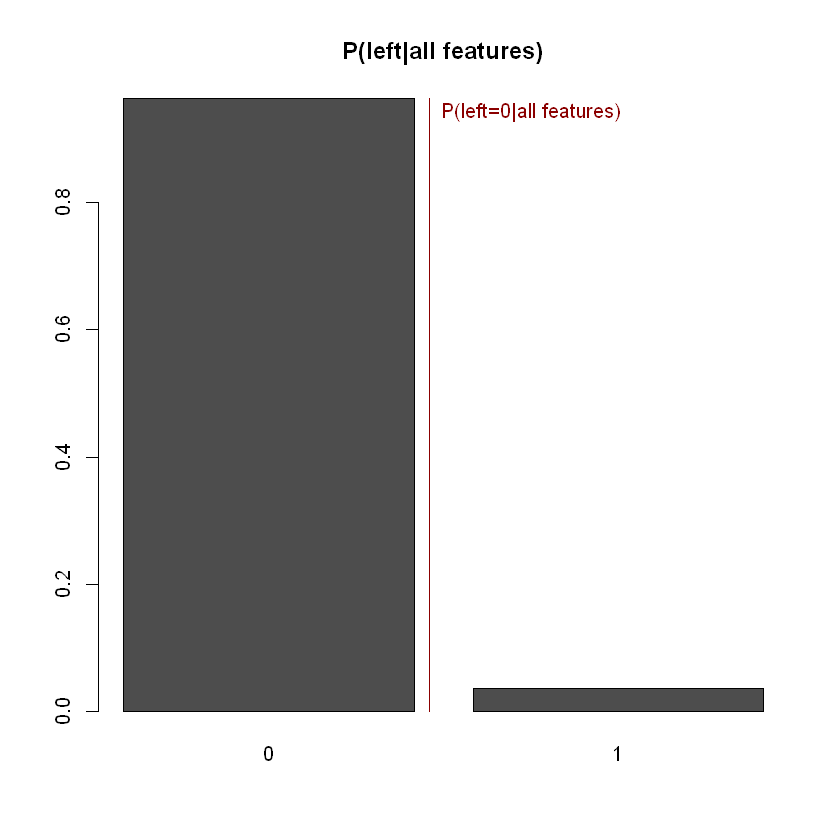

In [155]:
#visualison la distribution des probabilites de left avec la première instance de test
#cad la distribution a posteriori: de P(left|satisfaction_level, last_evaluation, number_project, average_montly_hours, time_spend_company, Work_accident, promotion_last_5years, department, salary)
barplot(pred1, main="P(left|all features)")

points(x=c(1.25,1.25), y=c(0,pred1[1]), type="l",col="darkred")
text(x=1.6,y=pred1[1]-0.02, labels="P(left=0|all features)",col="darkred")


In [156]:
#breaks for the histrograms
minX <- min(myData[,1])
maxX <- max(myData[,1])
breaks = seq(from = minX, to = maxX, length.out=20)

m<-model$tables$satisfaction_level[1, 1]
s<-model$tables$satisfaction_level[1, 2]

#lets draw the three conditional distributions

#dnorm is the density function of a normal distribution with mean=0 and sd=1
#curve draws the dnorm function from=minimum of petal width+some epsillo to=maximum of petal width + some epsillon, 
#                               the epsillon is there to have a range that includes all the possible values of petal_width
epsillon <- 0.7*(abs(min(myData[,1])-max(myData[,1])))


# Create the full path for the PDF file
full_pdf_path <- file.path(output_folder, paste0("satisfaction_level", "conditional_density_histogram", ".pdf"))

# Open a PDF to save the plots
pdf(file = full_pdf_path, width = 12, height = 6)


# Plot the normal density curve
curve(
		dnorm(x, mean = m, sd = s),
		from = minX - epsillon, to = maxX + epsillon,
		col = 4, lty = 2, lwd = 2,
		ylab = "Density", xlab = "satisfaction_level",
		main = "p(satisfaction_level | left = 1)",
		ylim=c(0, 5.5)

)

# Add the histogram for rows where left=1
hist(
		myData[myData$left == 1, "satisfaction_level"],
		breaks = breaks, freq = FALSE, add = TRUE
)

# Close the PDF device
dev.off()

# Confirm where the PDF was saved
cat("Plot saved as:", full_pdf_path, "\n")

png 
  2

Plot saved as: output/satisfaction_levelconditional_density_histogram.pdf 


In [169]:
# Function to plot class conditional distributions for quantitative variables
# Inputs:
# - myData: the dataset
# - nb: a naive Bayes model trained on that dataset
# - classColIndex: the index of the class attribute
# - quantitativeVarIndexes: indexes of the quantitative variables to plot
condDist <- function(myData, nb, classColIndex, quantitativeVarIndexes) {
	# Get the number of unique classes
	numClasses <- length(unique(myData[, classColIndex]))

	# Iterate over the specified quantitative variable indexes
	for (attribute in quantitativeVarIndexes) {
		par(mfrow = c(1, 2))  # Set the plotting layout

		# Retrieve conditional distribution stats for the current attribute
		condDistStats <- nb$tables[[attribute]]
		attrName <- names(nb$tables[attribute])
		classNames <- rownames(condDistStats)

		# Calculate the range for the variable
		minVal <- min(myData[, attribute])
		maxVal <- max(myData[, attribute])
		epsillon <- (abs(minVal - maxVal))

		# Set breaks for the histogram
		breaks <- seq(from = minVal - epsillon, to = maxVal + epsillon, length.out = 30)

		# Plot the density curves for each class
		add <- FALSE  # First plot creates a new figure
		for (classIndex in 1:numClasses) {
			m <- condDistStats[classIndex, 1]  # Mean
			s <- condDistStats[classIndex, 2]  # Standard deviation
			className <- classNames[classIndex]

			# Plot the normal density curve
			curve(
					dnorm(x, mean = m, sd = s),
					from = minVal - epsillon, to = maxVal + epsillon,
					col = classIndex, lty = 2, lwd = 2,
					ylab = "Density",
					main = paste("p(", attrName, "|", names(myData)[classColIndex], ")"),
					xlab = attrName, add = add
			)
			add <- TRUE
		}
		legend("topright", legend = classNames, fill = 1:numClasses)

		# Plot the histograms for each class
		add <- FALSE
		for (classIndex in 1:numClasses) {
			className <- classNames[classIndex]
			transparentColor <- adjustcolor(palette()[classIndex], alpha = 0.5)

			# Add histogram for each class
			hist(
					myData[myData[, classColIndex] == className, attribute],
					breaks = breaks,
					add = add, col = transparentColor,
					main = paste("p(", attrName, "|", names(myData)[classColIndex], ")"),
					xlab = attrName
			)
			add <- TRUE
		}
		legend("topright", legend = classNames, fill = 1:numClasses)
	}
}


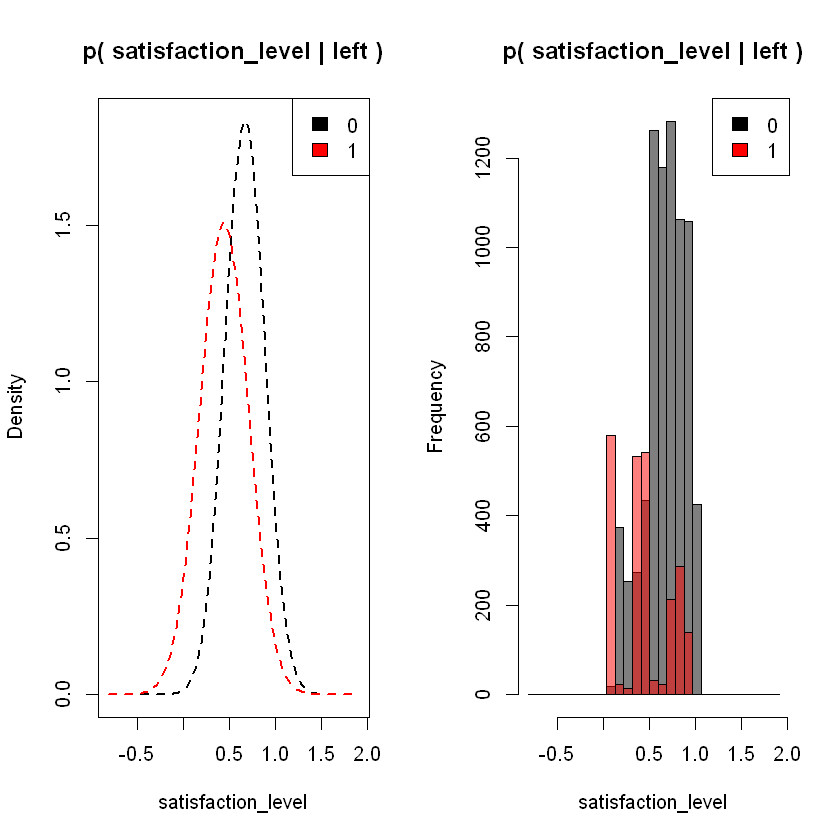

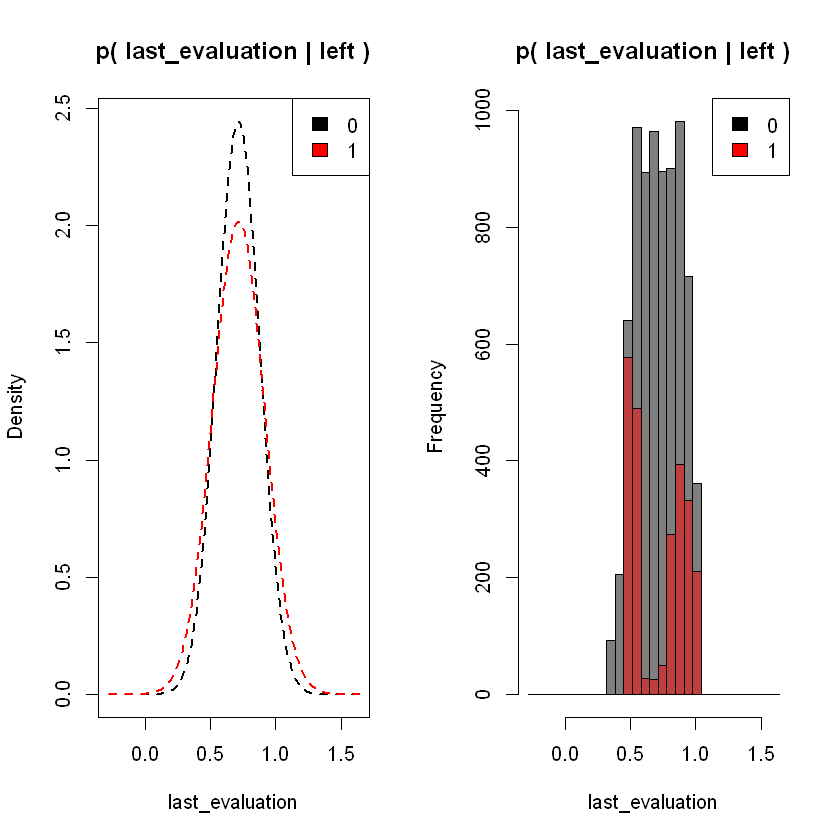

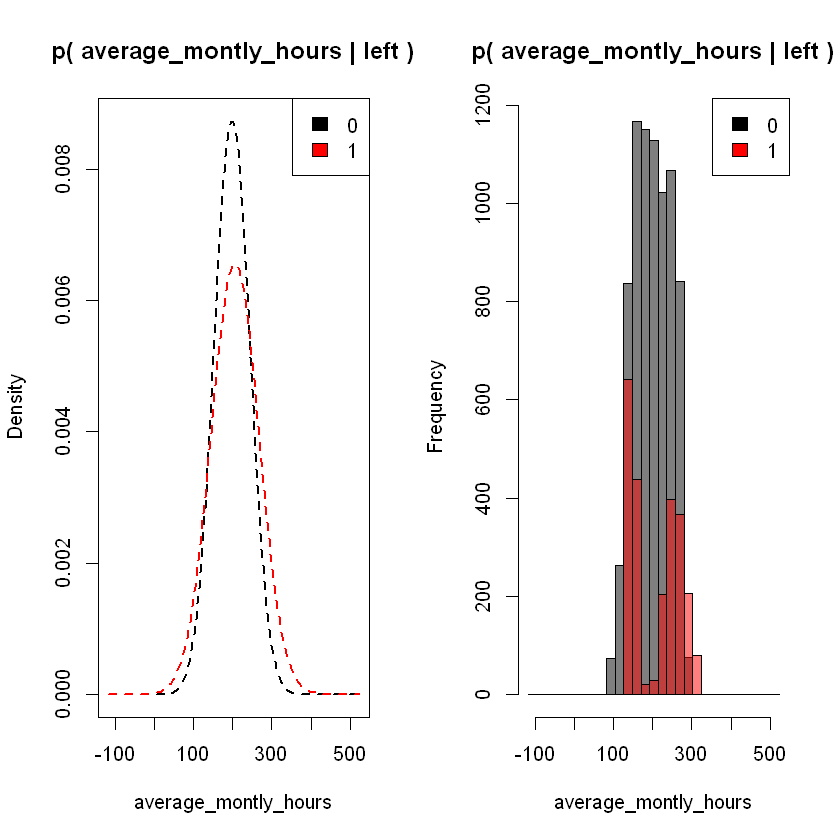

In [170]:
#Using colorspace Package, which allows to control colors transperancy
#while indexing colors with integer indeces
#Install and load the colorspace package if you haven't already
package_name <- "colorspace"
# Check if the package is installed
if (!require(package_name, character.only = TRUE)) {
	install.packages(package_name)
}
library(package_name, character.only = TRUE)
condDist(myData,model,target_variables_idx, quantitatives_attributes_col_idx)